In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc, and_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Reads column names and types
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [11]:
# Retrieve the most recent date
result = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)
for row in result:
    latest_date = row.date

# Convert to datetime format
conv_latest_date = dt.datetime.strptime(latest_date , '%Y-%m-%d')

In [12]:
# Calculate the date 1 year ago from the last data point in the database
last_12_months = conv_latest_date - dt.timedelta(days=365)

# Convert datetime to string
conv_last_12_months = last_12_months.strftime('%Y-%m-%d')

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precipitation = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date <= latest_date).\
                filter(Measurement.date >= conv_last_12_months).all()

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(precipitation, columns=["date", "precipitation"])
#prcp_df.set_index("date", inplace=True)
prcp_df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [15]:
# Sort the dataframe by date
prcp_df.sort_values(by="date", inplace=True)
prcp_df=prcp_df.reset_index(drop=True)
prcp_df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,NaN
2,2016-08-23,1.79
3,2016-08-23,0.05
4,2016-08-23,0.15


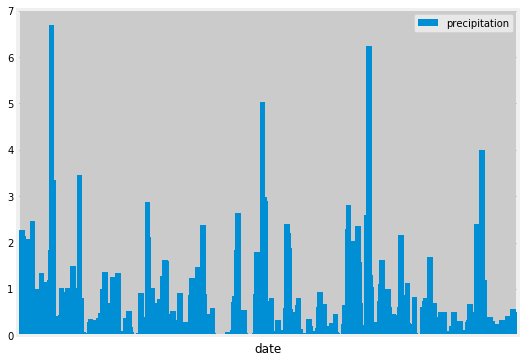

In [31]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot.bar("date","precipitation", figsize = (8,6), width=25)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.grid(True)

![precipitation](Images/precipitation.png)

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [18]:
# Reads column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
# Design a query to show how many stations are available in this dataset?
# stations = session.query(Station).count()
# stations

stations = session.query(Measurement.station).distinct().count()
stations

9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                  group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = active_stations[0]
station_id, freq = most_active_station

temp = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
               filter(Measurement.station == station_id)
for t in temp:
    print(t)

('USC00519281', 54.0, 85.0, 71.66378066378067)


In [22]:
# Choose the station with the highest number of temperature observations.
highest_temp_obv = session.query(Measurement.station, func.count(Measurement.tobs)).\
                  group_by(Measurement.station).order_by(desc(func.count(Measurement.tobs))).first()
highest_temp_obv

('USC00519281', 2772)

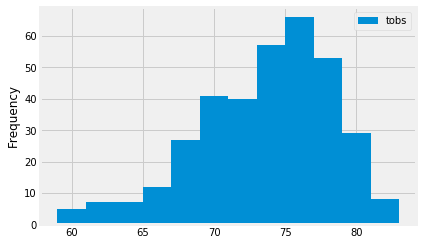

In [36]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obv = session.query(Measurement.date, Measurement.tobs).\
                filter(and_(Measurement.date <= latest_date, Measurement.date >= conv_last_12_months,Measurement.station == station_id)).all()

temp=[]
for record in temp_obv:
    temp.append(record[1])
num_bins = 12

plt.hist(temp, num_bins, label='tobs')
plt.ylabel('Frequency')
plt.legend()
plt.show()

![precipitation](Images/station-histogram.png)

In [37]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [40]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = '2016-07-01'
trip_end_date = '2016-07-12'

trip_calc_temp = calc_temps(trip_start_date, trip_end_date)
print(trip_calc_temp)

[(71.0, 77.02702702702703, 82.0)]


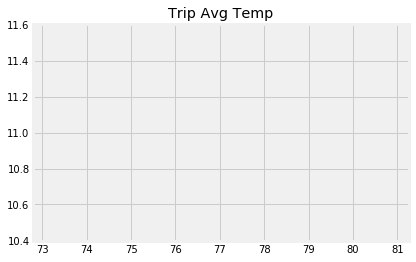

In [45]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
for t in trip_calc_temp:
    min_temp, avg_temp, max_temp = t

# yerr = max_temp - min_temp
# plt.errorbar(avg_temp, yerr)
# plt.title('Trip Avg Temp')
# plt.show()

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
